In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')
        
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [3]:
#add back the description of the proteins
desc_dict = {}
path = 'TriTrypDB-32_TbruceiTREU927_AnnotatedProteins.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc

In [4]:
#get glycosome data
ref_df = pd.read_csv('out_data/glycosome_experiment_extended.txt',sep='\t')    
ref_df['[Ortholog Group]']=ref_df['[Ortholog Group]'].astype('category')
ref_df['ortho_codes']=ref_df['[Ortholog Group]'].cat.codes
ref_df['[Input ID]']=[n.replace(' ','') for n in ref_df['[Input ID]']]
ref_df.set_index('[Input ID]',inplace=True)  
#print (ref_df.head())

lucia_experiments = pd.read_table('out_data/glycosome_experiment.txt',sep='\t')
lucia_experiments['[Input ID]']=lucia_experiments['GeneDB IDs']
lucia_experiments['[Input ID]']=[n.replace(' ','') for n in lucia_experiments['[Input ID]']]
lucia_experiments.set_index('[Input ID]',inplace=True)
#print (lucia_experiments.head())


ref_df = ref_df.join(lucia_experiments,how='left')
ref_df.drop_duplicates(subset=['[Gene ID]'],inplace=True)
ref_df.set_index('[Gene ID]',inplace=True,drop=True)
ref_df=ref_df[['Log2 H/L','Log10 (Int H*L)','Group', 'Glycosome status ']]
ref_df.head()

,Log2 H/L,Log10 (Int H*L),Group,Glycosome status
[Gene ID],,,,
Tb06.3A7.270,-0.113504,11.743189,i,red
Tb927.9.1350,0.020373,13.847976,i,red
Tb927.9.1360,0.034075,11.430029,i,red
Tb927.9.1380,0.158678,12.763610,i,red
Tb927.9.1410,0.002214,13.992089,i,red


In [5]:
#read data and log transform for plots
df = pd.read_csv('proteinGroups.txt',sep='\t')
df = clean(df)
df.head()
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df['logInt']=np.log10(df['Intensity'])
df['logRatio']=np.log2(df['Ratio H/L normalized'])
df['logScore']=np.log10(df['Score'])

removed  52 Only identified by site
tot  52  entries removed
---------------
removed  20 Reverse
tot  72  entries removed
---------------
removed  29 Potential contaminant
tot  101  entries removed
---------------


In [6]:
#get transmembrane and peptide signal from TryTripDB
tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)

df['[Input ID]'] = df['Gene_id']
df.set_index('[Input ID]',inplace=True)
df = df.join(tm, how='left')
df['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df['[SignalP Peptide]'] ] 



In [7]:
#add number of unique peptide identified
df['unique'] = [int(n.split(';')[0]) for n in df['Peptide counts (unique)']]

In [8]:
#select some fielsd from the full output
selection = df[['Gene_desc', 'unique','Score', 
                'Ratio H/L normalized', 'Intensity', 
                'logInt', 'logRatio','logScore', '[SignalP Peptide]','[# TM Domains]']]
selection.dropna(inplace=True)
selection.sort_values('logRatio',inplace=True,ascending =False)
selection=selection.join(ref_df, how='left')
selection.to_csv('label_free/txt/silac_clean.csv')
selection.head()

,Gene_desc,unique,Score,Ratio H/L normalized,Intensity,logInt,logRatio,logScore,[SignalP Peptide],[# TM Domains],Log2 H/L,Log10 (Int H*L),Group,Glycosome status
[Input ID],,,,,,,,,,,,,,
Tb927.11.9400,"hypothetical protein, conserved",4,4.7487,21.2700,1061800,6.026043,4.410748,0.676575,0,0.0,0.677496,14.766428,i,red
Tb927.5.1210,"short-chain dehydrogenase, putative",6,102.8800,13.6010,47788000,7.679319,3.765641,2.012331,1,2.0,3.368123,18.194598,iii,green
Tb927.11.12080,N-acetyl-D-glucosaminylphosphatidylinositol de...,2,29.8040,13.2970,3156700,6.499233,3.733029,1.474275,0,0.0,NaN,NaN,NaN,NaN
Tb927.11.6210,Lanosterol 14-alpha demethylase,4,4.3205,12.7250,4638000,6.666331,3.669594,0.635534,1,0.0,0.312071,15.682635,i,red
Tb927.10.4040,3-keto-dihydrosphingosine reductase,4,6.3210,9.7405,1800500,6.255393,3.283996,0.800786,1,1.0,1.866215,14.165572,ii,red


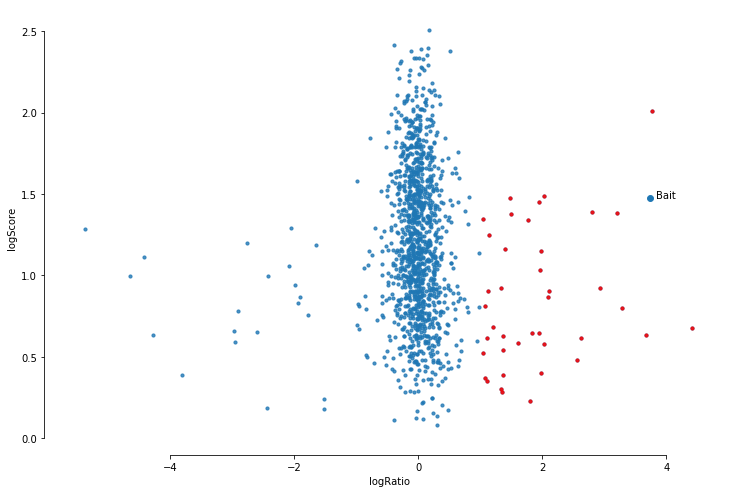

In [9]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='logRatio', y='logScore', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)


sns.regplot(x='logRatio', y='logScore', 
            fit_reg=False, data = selection[selection['logRatio']>1],
            ax=ax, scatter_kws={'s':10,'color':'red'})
sns.despine(offset=10, trim=True)



x_val = selection.loc['Tb927.11.12080']['logRatio']
y_val = selection.loc['Tb927.11.12080']['logScore']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )
plt.savefig('test_fig.svg')
plt.show()


In [43]:
#interactive plot
trace_1 = go.Scatter(
    x=selection.logRatio,
    y=selection.logInt,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(selection.index.values, selection.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = selection.logRatio, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[selection.logRatio.loc['Tb927.11.12080']],
    y=[selection.logInt.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)



layout = dict(title='MA')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

# Analysis of label free

In [25]:
def quantileNormalize(df_input, keep_na=True):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        norm = [rank[i] for i in t]
        if keep_na == True:
            norm = [np.nan if np.isnan(a) else b for a,b in zip(df[col],norm)]
        df[col] =  norm             
    return df


df_lf = pd.read_csv('label_free/txt/proteinGroups.txt',sep='\t')
df_lf = clean(df_lf)
df_lf['Gene_id'] = [clean_id(n.split(';')[0]) for n in df_lf['Protein IDs']]
df_lf['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df_lf['Gene_id']]
df_lf.set_index('Gene_id',inplace=True)
df_lf=df_lf.join(ref_df,how='left')

removed  33 Only identified by site
tot  33  entries removed
---------------
removed  12 Reverse
tot  45  entries removed
---------------
removed  36 Potential contaminant
tot  81  entries removed
---------------


In [27]:
#df_lf['MS/MS count DM-dig']=df_lf['MS/MS count DM-dig']+1
#df_lf['MS/MS count DM-tx']=df_lf['MS/MS count DM-tx']+1
#df_lf['MS/MS count TbGPI12-dig']=df_lf['MS/MS count TbGPI12-dig']+1
#df_lf['MS/MS count TbGPI12-tx']=df_lf['MS/MS count TbGPI12-tx']+1

df_lf['log2_ms_dig'] = np.log2((df_lf['MS/MS count TbGPI12-dig']+1)/(df_lf['MS/MS count DM-dig']+1))
df_lf['log2_ms_tx'] = np.log2((df_lf['MS/MS count TbGPI12-tx']+1)/(df_lf['MS/MS count DM-tx']+1))
                                      
df_lf['log10_int_dig']=np.log10(df_lf['Intensity DM-dig']+df_lf['Intensity TbGPI12-dig'])                                                       
df_lf['log10_int_tx'] = np.log10(df_lf['Intensity DM-tx']+df_lf['Intensity TbGPI12-tx'])
                                       
df_lf.to_csv('label_free/txt/proteinGroups_clean.csv')
df_lf.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Oxidation (M) site positions,Gene_desc,Log2 H/L,Log10 (Int H*L),Group,Glycosome status,log2_ms_dig,log2_ms_tx,log10_int_dig,log10_int_tx
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4560,Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...,Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...,4;4;4,4;4;4,4;4;4,;;,3,4,4,4,...,NaN,"guanine deaminase, putative",NaN,NaN,NaN,NaN,-2.000000,1.000000,5.744840,4.566331
Tb927.7.2140,Tb927.7.2140:mRNA-p1;Tb07.11L3.90:mRNA-p1,Tb927.7.2140:mRNA-p1;Tb07.11L3.90:mRNA-p1,6;6,6;6,6;6,;,2,6,6,6,...,NaN,"zinc finger protein family member, putative",0.307005,14.474540,i,red,-1.584963,1.584963,6.354337,4.884416
Tb11.v5.0767,Tb11.v5.0767.1-p1;Tb927.10.4430:mRNA-p1;Tb10.v...,Tb11.v5.0767.1-p1;Tb927.10.4430:mRNA-p1;Tb10.v...,2;2;2,2;2;2,2;2;2,;;,3,2,2,2,...,NaN,"pumillo RNA binding protein PUF1, putative",NaN,NaN,NaN,NaN,-1.584963,0.000000,5.642939,-inf
Tb927.10.4450,Tb927.10.4450:mRNA-p1;Tb11.v5.0757.1-p1;Tb10.v...,Tb927.10.4450:mRNA-p1;Tb11.v5.0757.1-p1;Tb10.v...,4;4;4,4;4;4,4;4;4,;;,3,4,4,4,...,NaN,"stress-inducible protein STI1-like, putative",NaN,NaN,NaN,NaN,-1.807355,0.000000,5.482599,-inf
Tb927.10.4460,Tb927.10.4460:mRNA-p1;Tb10.v4.0036:mRNA-p1,Tb927.10.4460:mRNA-p1;Tb10.v4.0036:mRNA-p1,1;1,1;1,1;1,;,2,1,1,1,...,NaN,"leucine carboxyl methyltransferase, putative",0.164786,14.415725,i,red,0.000000,-1.584963,-inf,4.644153


Text(3.1,6.28731,'Bait')

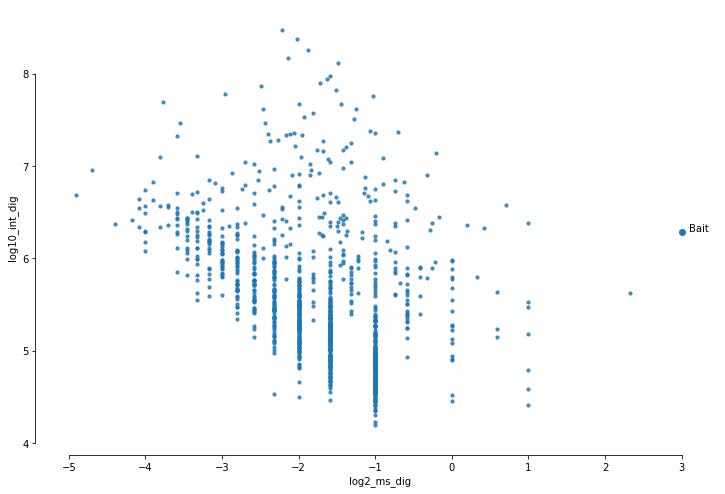

In [28]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_ms_dig', y='log10_int_dig', 
            fit_reg=False, data = df_lf,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf.loc['Tb927.11.12080']['log2_ms_dig']
y_val = df_lf.loc['Tb927.11.12080']['log10_int_dig']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )


In [33]:
#interactive plot
trace_1 = go.Scatter(
    x=df_lf.log2_ms_dig,
    y=df_lf.log10_int_dig,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(df_lf.index.values, df_lf.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = df_lf.log2_ms_dig, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[df_lf.log2_ms_dig.loc['Tb927.11.12080']],
    y=[df_lf.log10_int_dig.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)

annot_2 = go.Scatter(
    x=[df_lf.log2_ms_dig.loc['Tb927.10.4040']],
    y=[df_lf.log10_int_dig.loc['Tb927.10.4040']],
    mode='markers+text',
    name='Tb927.10.4040 3-keto-dihydrosphingosine reductase',
    text=['3-keto-dihydrosphingosine reductase'],
    textposition='bottom center'
)


layout = dict(title='MA')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

Text(3.68496,6.06423,'Bait')

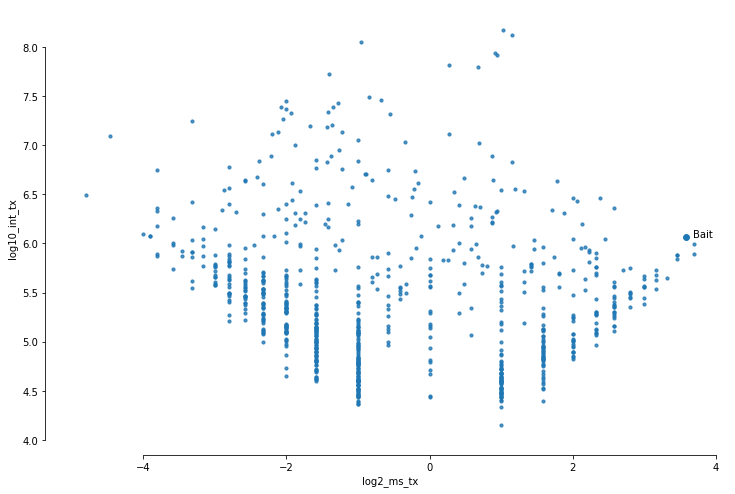

In [30]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_ms_tx', y='log10_int_tx', 
            fit_reg=False, data = df_lf,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf.loc['Tb927.11.12080']['log2_ms_tx']
y_val = df_lf.loc['Tb927.11.12080']['log10_int_tx']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )


In [37]:
#interactive plot
trace_1 = go.Scatter(
    x=df_lf.log2_ms_tx,
    y=df_lf.log10_int_tx,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(df_lf.index.values, df_lf.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = df_lf.log2_ms_tx, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[df_lf.log2_ms_tx.loc['Tb927.11.12080']],
    y=[df_lf.log10_int_tx.loc['Tb927.11.12080']],
    mode='markers+text',
    name='Tb927.11.12080',
    text=['Bait'],
    textposition='bottom center'
)

annot_2 = go.Scatter(
    x=[df_lf.log2_ms_tx.loc['Tb927.10.4040']],
    y=[df_lf.log10_int_tx.loc['Tb927.10.4040']],
    mode='markers+text',
    name='Tb927.10.4040 3-keto-dihydrosphingosine reductase',
    text=['3-keto-dihydrosphingosine reductase'],
    textposition='bottom center'
)


layout = dict(title='MA')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

# Second Label Free

In [49]:
df_lf2 = pd.read_csv('20180820 TbdeAc2 labeel free data-1/proteinGroups.txt',sep='\t')
df_lf2 = clean(df_lf2)
df_lf2['Gene_id'] = [clean_id(n.split(';')[0]) for n in df_lf2['Protein IDs']]
df_lf2['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df_lf2['Gene_id']]
df_lf2.set_index('Gene_id',inplace=True)
df_lf2=df_lf2.join(ref_df,how='left')


df_lf2['log2_DEAC2'] = np.log2((df_lf2['MS/MS count DEAC2']+1)/(df_lf2['MS/MS count SM']+1))
df_lf2['log10_int']=np.log10(df_lf2['Intensity DEAC2']+df_lf2['Intensity SM'])                                                                                             
df_lf2.to_csv('20180820 TbdeAc2 labeel free data-1/proteinGroups_clean.csv')
df_lf2.head()

removed  23 Only identified by site
tot  23  entries removed
---------------
removed  21 Reverse
tot  44  entries removed
---------------
removed  42 Potential contaminant
tot  86  entries removed
---------------


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Gene_desc,Log2 H/L,Log10 (Int H*L),Group,Glycosome status,log2_DEAC2,log10_int
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4460,Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...,Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...,30;30;15,30;30;15,30;30;15,;;,3,30,30,30,...,1047;3557;3607;6379;8427;8493;8555;9073;9079;9...,55;56;57;58,251;405;481;797,"major vault protein, putative",0.263531,14.050605,i,red,1.530515,7.480007
Tb927.5.4480,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,1;1,1;1,1;1,;,2,1,1,1,...,5111,NaN,NaN,"paraflagellar rod component par4, putative",0.035299,14.193449,i,red,1.000000,4.602841
Tb927.5.4500,Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1,Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1,7;7,7;7,7;7,;,2,7,7,7,...,3215;12749;21853;27242;28571;29321;31384,59,112,"ras-like small GTPase, putative",0.429018,16.998218,i,red,-0.263034,7.008166
Tb927.5.4360,Tb927.5.4360:mRNA-p1;Tb05.5K5.20:mRNA-p1,Tb927.5.4360:mRNA-p1;Tb05.5K5.20:mRNA-p1,1;1,1;1,1;1,;,2,1,1,1,...,23978,NaN,NaN,"hypothetical protein, conserved",NaN,NaN,NaN,NaN,1.000000,5.194181
Tb927.5.4560,Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...,Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...,10;10;10,10;10;10,10;10;10,;;,3,10,10,10,...,1596;1730;3878;13142;14332;23426;23576;28267;2...,NaN,NaN,"guanine deaminase, putative",NaN,NaN,NaN,NaN,-0.415037,6.625477


Text(4.80044,6.98928,'Bait')

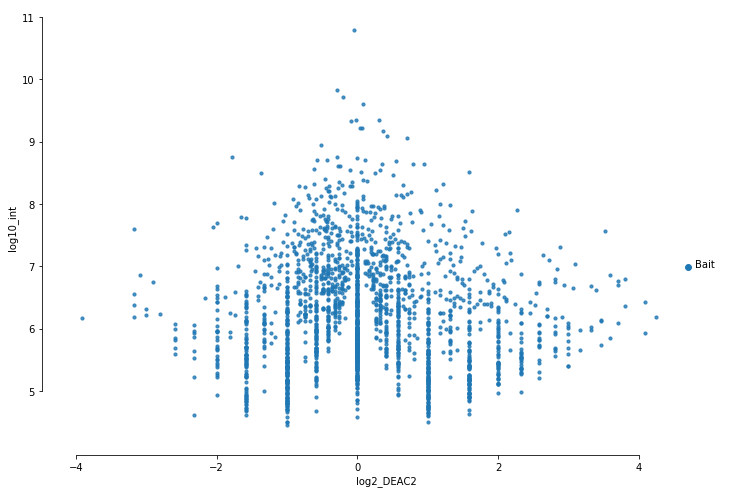

In [50]:
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='log2_DEAC2', y='log10_int', 
            fit_reg=False, data = df_lf2,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
x_val = df_lf2.loc['Tb927.3.2610']['log2_DEAC2']
y_val = df_lf2.loc['Tb927.3.2610']['log10_int']
ax.scatter(x_val,y_val, s=35)
ax.annotate('Bait', xy=(x_val, y_val), xytext=(x_val+0.1, y_val),
            )

In [51]:

#interactive plot
trace_1 = go.Scatter(
    x=df_lf2.log2_DEAC2,
    y=df_lf2.log10_int,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(df_lf2.index.values, df_lf2.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = df_lf2.log2_DEAC2, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)

annot_1 = go.Scatter(
    x=[df_lf2.log2_DEAC2.loc['Tb927.3.2610']],
    y=[df_lf2.log10_int.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)




layout = dict(title='MA')


fig = go.Figure(data=[trace_1, annot_1], 
                layout=layout)
iplot(fig, filename='test')

# Make Interactive PLOT

In [39]:
'''
upep_from_col = set(selection['unique'])
upep_ints = sorted(list(upep_from_col))
upeps = [str(up) for up in upep_ints]


# make list of continents
tm_domains = list(set(selection['[# TM Domains]']))

columns = []
# make grid
for up in upeps:
    for tm in tm_domains:
        dataset_by_year = selection[selection['unique'] == int(up)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['[# TM Domains]'] == tm]
        for col_name in dataset_by_year_and_cont:
            #print (col_name)
            # each column name is unique
            column_name = '{unique_pep}_{tm}_{header}_gapminder_grid'.format(
                unique_pep=up, tm=tm, header=col_name
            )
            a_column = Column(list(dataset_by_year_and_cont[col_name]), column_name)
            columns.append(a_column)

# upload grid
grid = Grid(columns)

figure = {
    'data': [],
    'layout': {},
    'frames': [],
    'config': {'scrollzoom': True}
}

# fill in most of layout
figure['layout']['xaxis'] = {'logRatio': 'logRatio', 'title': 'Log 2 Fold change', 'gridcolor': '#FFFFFF'}
figure['layout']['yaxis'] = {'title': 'GDP per Capita', 'type': 'log', 'gridcolor': '#FFFFFF'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['plot_bgcolor'] = 'rgb(223, 232, 243)'
'''